In [1]:
#Install necessary libraries

import numpy as np
import pandas as pd
import requests
# KO : pip install folium
# KO : conda install -c conda-forge folium
# KO : python3 -m pip install folium
!pip install folium
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize

# add bs4 library:
from bs4 import BeautifulSoup
import lxml

import types

print('Libraries imported.')



     |████████████████████████████████| 93 kB 3.5 MB/s  eta 0:00:01
Libraries imported.


In [92]:
# download data and parse it:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(r.text, 'html.parser')
table=soup.find('table', attrs={'class':'wikitable sortable'})

#get headers:
headers=table.findAll('th')
for i, head in enumerate(headers): headers[i]=str(headers[i]).replace("<th>","").replace("</th>","").replace("\n","")

#Find all items and skip first one:
rows=table.findAll('tr')
rows=rows[1:len(rows)]

# skip all meta symbols and line feeds between rows:
for i, row in enumerate(rows): rows[i] = str(rows[i]).replace("\n</td></tr>","").replace("<tr>\n<td>","")

# make dataframe, expand rows and drop the old one:
df=pd.DataFrame(rows)
df[headers] = df[0].str.split("</td>\n<td>", n = 2, expand = True) 
df.drop(columns=[0],inplace=True)

# skip not assigned boroughs:
df = df.drop(df[(df.Borough == "Not assigned")].index)
# give "Not assigned" Neighborhoods same name as Borough:
df.Neighbourhood.replace("Not assigned", df.Borough, inplace=True)

# copy Borough value to Neighborhood if NaN:
df.Neighbourhood.fillna(df.Borough, inplace=True)
# drop duplicate rows:
df=df.drop_duplicates()

# extract titles from columns
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

df.update(
    df.Borough.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

# delete Toronto annotation from Neighbourhood:
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace(", Toronto",""))
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace("\(Toronto\)",""))

df["Postal Code"] = df["Postal Code"].str.replace("\n","")
df["Borough"] = df["Borough"].str.replace("\n","")

# combine multiple neighborhoods with the same post code
df2 = df
df2['Borough']=pd.DataFrame(list(set(df['Borough'].loc[df['Postal Code'] == x['Postal Code']])) for i, x in df2.iterrows())
df2['Neighborhood']=pd.Series(list(set(df['Neighbourhood'].loc[df['Postal Code'] == x['Postal Code']])) for i, x in df2.iterrows())
df2['Neighborhood']=df2['Neighborhood'].apply(lambda x: ', '.join(x))
df2.dtypes
df2["Neighbourhood"] = df2["Neighbourhood"].str.replace("\n","")
del df2['Neighborhood']

# print("Shape: ", df2.shape) GIVES Shape:  (180, 3)

# Get names of indexes for which Borough has value Not assigned
indexNames = df[ df['Borough'] == 'Not assigned' ].index
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

df2['Neighborhood'] = df2['Neighbourhood']
del df2['Neighbourhood']

df2.head()

# print("Shape: ", df2.shape) GIVES Shape:  (103, 3)

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [78]:
# Creating a dataframe for the coords ( i used the "insert to code" auto coding with my Geo_coords.csv file ):

from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_a1140d790ce14c33a9a851b87ceefe6e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='t_cp9LWHTOIdVnWEuKUw7CyY_Cvb1duGM29kbYhCfUCm',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_a1140d790ce14c33a9a851b87ceefe6e.get_object(Bucket='segmentingandclusteringneighborho-donotdelete-pr-qxbtqpuvzj0bnl',Key='Geo_coords.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [93]:
# 2 dataframes merging :
df_toronto = pd.merge(df2, df_data_1, how='left', left_on = 'Postal Code', right_on = 'Postal Code')
# remove the "Postal Code" column
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [80]:
address = "Toronto, ON"

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create the map of Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=15)
map_toronto



In [85]:
# Adding markers to the map :
for lat, lng, borough, neighborhood in zip(
        df_toronto['Latitude'], 
        df_toronto['Longitude'], 
        df_toronto['Borough'], 
        df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

In [94]:
#creating a dataframe for the center only :

df_toronto_CENTER = df_toronto[df_toronto['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto_CENTER.head()

#mapping the center only :
map_toronto_CENTER = folium.Map(location=[latitude, longitude], zoom_start=15)
for lat, lng, borough, neighborhood in zip(
        df_toronto_CENTER['Latitude'], 
        df_toronto_CENTER['Longitude'], 
        df_toronto_CENTER['Borough'], 
        df_toronto_CENTER['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_CENTER)  

map_toronto_CENTER

In [9]:
# Preparing using foursquare too add datas

CLIENT_ID = 'D2UTXGPHJSV1EZPUIELAVLBHIQCAE2NPSX3RQELPOM0FR3L3'
CLIENT_SECRET = 'LUMKAZTMRTQGUZIDB4VNF1NRI5DB2RUP0N3NPSSIYE1M3XNS'
VERSION = '20180605'
LIMIT =100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [87]:
# Using foursquare too add datas to the center

toronto_CENTER_venues = getNearbyVenues(names=df_toronto_CENTER['Neighborhood'],
                                   latitudes=df_toronto_CENTER['Latitude'],
                                   longitudes=df_toronto_CENTER['Longitude']
                                  )

toronto_CENTER_venues.head

<bound method NDFrame.head of                                            Neighborhood  \
0                             Regent Park, Harbourfront   
1                             Regent Park, Harbourfront   
2                             Regent Park, Harbourfront   
3                             Regent Park, Harbourfront   
4                             Regent Park, Harbourfront   
...                                                 ...   
1615  Business reply mail Processing Centre, South C...   
1616  Business reply mail Processing Centre, South C...   
1617  Business reply mail Processing Centre, South C...   
1618  Business reply mail Processing Centre, South C...   
1619  Business reply mail Processing Centre, South C...   

      Neighborhood Latitude  Neighborhood Longitude                    Venue  \
0                 43.654260              -79.360636         Roselle Desserts   
1                 43.654260              -79.360636            Tandem Coffee   
2                 43.

In [88]:
# data exploration of CENTER - Number of venues per neighborhood
toronto_CENTER_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",15,15,15,15,15,15
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,66,66,66,66,66,66
Christie,16,16,16,16,16,16
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,35,35,35,35,35,35


In [89]:
# Preparation of the clustering of the CENTER (Normalisation ):

# one neighborhood
toronto_CENTER_one = pd.get_dummies(toronto_CENTER_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_CENTER_one['Neighborhood'] = toronto_CENTER_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_CENTER_one.columns[-1]] + list(toronto_CENTER_one.columns[:-1])
toronto_CENTER_one = toronto_CENTER_one[fixed_columns]

toronto_CENTER_grouped = toronto_CENTER_one.groupby('Neighborhood').mean().reset_index()
toronto_CENTER_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.017241,0.0,0.0,0.000000,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,"Business reply mail Processing Centre, South C...",0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,Central Bay Street,0.015152,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.015152,0.0,0.0,0.015152,0.0


In [90]:
# Clustering of the CENTER :

toronto_CENTER_grouped_clustering = toronto_CENTER_grouped.drop('Neighborhood', 1)
toronto_CENTER_grouped_clustering.head()

,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.017241,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.015152,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.015152,0.0,0.0,0.015152,0.0


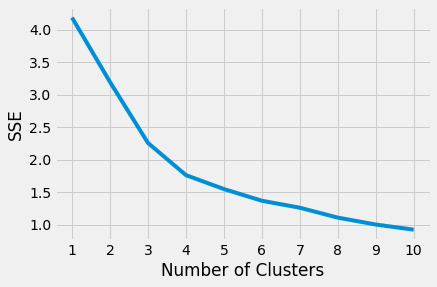

In [54]:
sse = []
# set number of clusters
for kclusters in range(1, 11):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, max_iter=300).fit(toronto_CENTER_grouped_clustering)
    sse.append(kmeans.inertia_)

import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()




In [67]:
# set number of clusters to 5
# run k-means clustering only with 5
kmeans = KMeans(n_clusters=5, random_state=0, max_iter=300).fit(toronto_CENTER_grouped_clustering)
kmeans.inertia_

1.5494581471337856

In [91]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_CENTER_grouped['Neighborhood']

for ind in np.arange(toronto_CENTER_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_CENTER_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Cheese Shop,Beer Bar,Restaurant,Seafood Restaurant,Concert Hall,Basketball Stadium
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Bakery,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant,Burrito Place
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Auto Workshop,Pizza Place,Brewery,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant,Skate Park,Garden Center
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Boat or Ferry,Harbor / Marina,Boutique,Rental Car Location,Bar,Coffee Shop,Sculpture Garden
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint,Salad Place,Thai Restaurant,Bubble Tea Shop,Yoga Studio,Indian Restaurant


In [95]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_toronto_CENTER_with_label = df_toronto_CENTER.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_toronto_CENTER_with_label.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Bakery,Park,Café,Pub,Breakfast Spot,Theater,Wine Shop,Event Space,Performing Arts Venue
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Sushi Restaurant,Yoga Studio,Discount Store,Fast Food Restaurant,Beer Bar,Smoothie Shop,Italian Restaurant,Sandwich Place,Distribution Center
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Cosmetics Shop,Middle Eastern Restaurant,Japanese Restaurant,Hotel,Bookstore,Ramen Restaurant
3,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,American Restaurant,Gastropub,Cocktail Bar,Cosmetics Shop,Clothing Store,Moroccan Restaurant,Seafood Restaurant,Restaurant
4,East Toronto,The Beaches,43.676357,-79.293031,2,Asian Restaurant,Trail,Pub,Health Food Store,Coffee Shop,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dance Studio


In [97]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_toronto_CENTER_with_label['Latitude'], 
        df_toronto_CENTER_with_label['Longitude'], 
        df_toronto_CENTER_with_label['Neighborhood'], 
        df_toronto_CENTER_with_label['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [100]:
# CLUSTER 0 (PARK) in RED on the map: 
df_toronto_CENTER_with_label.loc[df_toronto_CENTER_with_label['Cluster Labels'] == 0, 
df_toronto_CENTER_with_label.columns[[1] + list(range(5, df_toronto_CENTER_with_label.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Davisville North,Department Store,Sandwich Place,Park,Hotel,Gym / Fitness Center,Breakfast Spot,Food & Drink Shop,Dessert Shop,Diner,Discount Store
21,"Forest Hill North &amp; West, Forest Hill Road...",Park,Jewelry Store,Trail,Sushi Restaurant,Wine Shop,Deli / Bodega,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant
33,Rosedale,Park,Playground,Trail,Dance Studio,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run


In [101]:
# CLUSTER 1 : (GARDEN) in LIGHT BLUE at the south on the map: 
df_toronto_CENTER_with_label.loc[df_toronto_CENTER_with_label['Cluster Labels'] == 1, 
df_toronto_CENTER_with_label.columns[[1] + list(range(5, df_toronto_CENTER_with_label.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,Garden,Wine Shop,Dance Studio,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


In [102]:
# CLUSTER 2 : (Coffee Shop) in VIOLET on the map: 
df_toronto_CENTER_with_label.loc[df_toronto_CENTER_with_label['Cluster Labels'] == 2, 
df_toronto_CENTER_with_label.columns[[1] + list(range(5, df_toronto_CENTER_with_label.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",Coffee Shop,Bakery,Park,Café,Pub,Breakfast Spot,Theater,Wine Shop,Event Space,Performing Arts Venue
1,"Queen's Park, Ontario Provincial Government",Coffee Shop,Sushi Restaurant,Yoga Studio,Discount Store,Fast Food Restaurant,Beer Bar,Smoothie Shop,Italian Restaurant,Sandwich Place,Distribution Center
2,"Garden District, Ryerson",Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Cosmetics Shop,Middle Eastern Restaurant,Japanese Restaurant,Hotel,Bookstore,Ramen Restaurant
3,St. James Town,Coffee Shop,Café,American Restaurant,Gastropub,Cocktail Bar,Cosmetics Shop,Clothing Store,Moroccan Restaurant,Seafood Restaurant,Restaurant
4,The Beaches,Asian Restaurant,Trail,Pub,Health Food Store,Coffee Shop,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dance Studio
5,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Cheese Shop,Beer Bar,Restaurant,Seafood Restaurant,Concert Hall,Basketball Stadium
6,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint,Salad Place,Thai Restaurant,Bubble Tea Shop,Yoga Studio,Indian Restaurant
7,Christie,Grocery Store,Café,Park,Baby Store,Candy Store,Restaurant,Italian Restaurant,Athletics & Sports,Coffee Shop,Nightclub
8,"Richmond, Adelaide, King",Coffee Shop,Café,Restaurant,Thai Restaurant,Deli / Bodega,Gym,Hotel,American Restaurant,Concert Hall,Sushi Restaurant
9,"Dufferin, Dovercourt Village",Pharmacy,Bakery,Park,Brewery,Café,Bar,Bank,Supermarket,Pool,Playground


In [105]:
# CLUSTER 3 : (Dance Studio) in LIGHT BLUE on the map: 
df_toronto_CENTER_with_label.loc[df_toronto_CENTER_with_label['Cluster Labels'] == 3, 
df_toronto_CENTER_with_label.columns[[1] + list(range(5, df_toronto_CENTER_with_label.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,"Moore Park, Summerhill East",Restaurant,Dance Studio,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


In [106]:
# CLUSTER 4 : (Park and Swim School) in LIGHT BLUE at the north on the map:
df_toronto_CENTER_with_label.loc[df_toronto_CENTER_with_label['Cluster Labels'] == 4, 
df_toronto_CENTER_with_label.columns[[1] + list(range(5, df_toronto_CENTER_with_label.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Lawrence Park,Park,Swim School,Bus Line,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run
